<H3><b>Fine Tuning VVG16, VGG19, ResNet18, ResNet34 and ResNet50 by adding an Additional linear layer with 256 output features, ReLU activation and Dropout Layer of 50% Probability with the All Layers Frozen

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#necessary imports
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import gc

In [ ]:
# Define the number of classes in your dataset
num_classes = 2
dropout_prob = 0.5
criterion = nn.CrossEntropyLoss()
num_epochs = 5

In [ ]:
#define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#defining transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  #resize images to 224x224
        transforms.RandomHorizontalFlip(),  #randomly flip images horizontally
        transforms.ToTensor(),  #convert images to PyTorch tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #normalize images
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [ ]:
!unzip -q "/content/drive/My Drive/images dataset.zip" -d "/content/dataset"


In [ ]:
path = "/content/dataset"


In [ ]:
!ls "/content/dataset"

autism-2.txt  autism-S-224-89.33.h5  consolidated  test  train	valid


In [ ]:
# Define transforms for data augmentation and normalization
transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:

train_dataset = datasets.ImageFolder(root=path+"/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

validation_dataset = datasets.ImageFolder(root=path+"/valid", transform=transform)
validation_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder(root=path+"/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train':train_loader, 'valid':validation_loader, 'test':test_loader}

# Determine dataset sizes
dataset_sizes = {}
dataset_sizes['train'] = len(train_dataset)
dataset_sizes['valid'] = len(validation_dataset)
dataset_sizes['test'] = len(test_dataset)

<H4><b>Model Training

In [ ]:
# Define function for training a model
def train_model(model, criterion, optimizer, dataloaders, num_epochs=5):
    model.to(device)
    train_acc_history = []
    valid_acc_history = []

    train_loss_history = []
    valid_loss_history = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # print(inputs)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
            else:
                valid_acc_history.append(epoch_acc)

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                valid_loss_history.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    return model, train_acc_history, valid_acc_history, train_loss_history, valid_loss_history

<h4><b>Model Evaluation

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Collect predictions and true labels
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    print('Accuracy: {:.4f}'.format(accuracy))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1-score: {:.4f}'.format(f1))


<h4><B>VGG16

In [ ]:
model_vgg16 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 119MB/s]


In [ ]:
# Freeze the layers in the base model
for param in model_vgg16.parameters():
    param.requires_grad = False

# Check the number of input features for the fully connected layer
num_features_vgg16 = model_vgg16.classifier[6].in_features


# Modify the fully connected layers
model_vgg16.classifier[6] = nn.Sequential(
    nn.Linear(num_features_vgg16, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)

model_vgg16 = model_vgg16.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_vgg16.parameters(), lr=0.0001)
torch.cuda.empty_cache()
gc.collect()

44

In [ ]:
# Train the model
model_vgg16, train_acc_vgg16, valid_acc_vgg16, train_loss_vgg16, valid_loss_vgg16 = train_model(model_vgg16, criterion, optimizer_ft, dataloaders,
                                                             num_epochs)

Epoch 1/10
----------
train Loss: 0.6146 Acc: 0.6558
valid Loss: 0.5541 Acc: 0.7228
Epoch 2/10
----------
train Loss: 0.5551 Acc: 0.7161
valid Loss: 0.5143 Acc: 0.7555
Epoch 3/10
----------
train Loss: 0.5326 Acc: 0.7323
valid Loss: 0.5023 Acc: 0.7555
Epoch 4/10
----------
train Loss: 0.5250 Acc: 0.7386
valid Loss: 0.4819 Acc: 0.7677
Epoch 5/10
----------
train Loss: 0.5141 Acc: 0.7421
valid Loss: 0.4739 Acc: 0.7744
Epoch 6/10
----------
train Loss: 0.5070 Acc: 0.7559
valid Loss: 0.4800 Acc: 0.7626
Epoch 7/10
----------
train Loss: 0.5003 Acc: 0.7547
valid Loss: 0.4529 Acc: 0.7997
Epoch 8/10
----------
train Loss: 0.5057 Acc: 0.7535
valid Loss: 0.4635 Acc: 0.7792
Epoch 9/10
----------
train Loss: 0.4975 Acc: 0.7591
valid Loss: 0.4530 Acc: 0.7926
Epoch 10/10
----------
train Loss: 0.4800 Acc: 0.7685
valid Loss: 0.4512 Acc: 0.7843


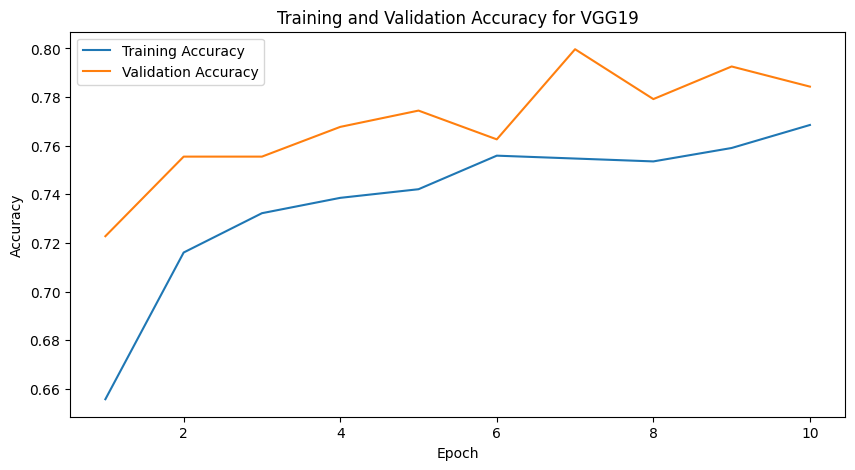

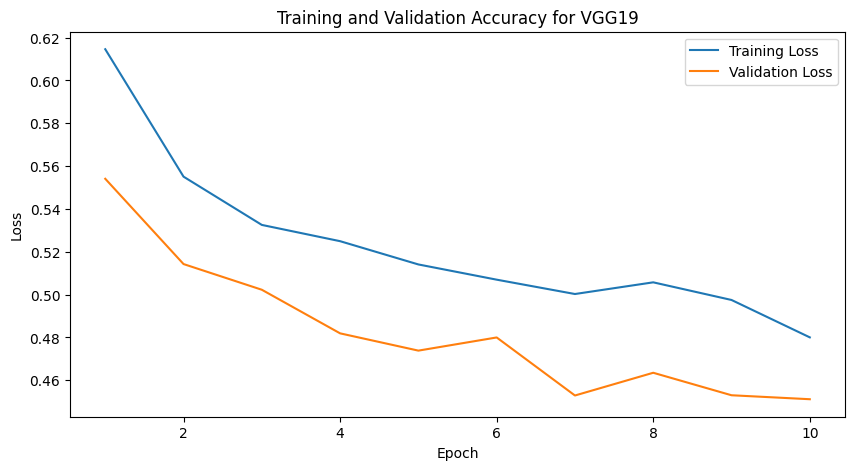

In [ ]:
# Move the accuracies to CPU
train_acc_vgg16_cpu = [acc.cpu().numpy() for acc in train_acc_vgg16]
valid_acc_vgg16_cpu = [acc.cpu().numpy() for acc in valid_acc_vgg16]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_vgg16_cpu) + 1), train_acc_vgg16_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_vgg16_cpu) + 1), valid_acc_vgg16_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for VGG16')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_vgg16) + 1), train_loss_vgg16, label='Training Loss')
plt.plot(range(1, len(valid_loss_vgg16) + 1), valid_loss_vgg16, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for VGG16')
plt.legend()
plt.show()

In [ ]:
print("Evaluating VGG16 on the test set...")
evaluate_model(model_vgg16, dataloaders['test'])

Evaluating VGG16 on the test set...
Accuracy: 0.7733
Precision: 0.7303
Recall: 0.8667
F1-score: 0.7927


<h4><B>VGG19

In [ ]:
model_vgg19 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 88.6MB/s]


In [ ]:
# Freeze the layers in the base model
for param in model_vgg19.parameters():
    param.requires_grad = False

# Check the number of input features for the fully connected layer
num_features_vgg19 = model_vgg19.classifier[6].in_features

# Modify the fully connected layers
model_vgg19.classifier[6] = nn.Sequential(
    nn.Linear(num_features_vgg19, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)

model_vgg19 = model_vgg19.to(device)
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_vgg19.parameters(), lr=0.0001)

torch.cuda.empty_cache()
gc.collect()

7669

In [ ]:
# Train the model
model_vgg19, train_acc_vgg19, valid_acc_vgg19, train_loss_vgg19, valid_loss_vgg19 = train_model(model_vgg19, criterion, optimizer_ft, dataloaders,
                                                             num_epochs)

Epoch 1/10
----------
train Loss: 0.6032 Acc: 0.6684
valid Loss: 0.5417 Acc: 0.7259
Epoch 2/10
----------
train Loss: 0.5438 Acc: 0.7244
valid Loss: 0.5053 Acc: 0.7492
Epoch 3/10
----------
train Loss: 0.5326 Acc: 0.7323
valid Loss: 0.4843 Acc: 0.7685
Epoch 4/10
----------
train Loss: 0.5201 Acc: 0.7263
valid Loss: 0.4849 Acc: 0.7677
Epoch 5/10
----------
train Loss: 0.5042 Acc: 0.7484
valid Loss: 0.4755 Acc: 0.7784
Epoch 6/10
----------
train Loss: 0.5030 Acc: 0.7563
valid Loss: 0.4906 Acc: 0.7599
Epoch 7/10
----------
train Loss: 0.4996 Acc: 0.7559
valid Loss: 0.4710 Acc: 0.7768
Epoch 8/10
----------
train Loss: 0.4906 Acc: 0.7528
valid Loss: 0.4611 Acc: 0.7827
Epoch 9/10
----------
train Loss: 0.4862 Acc: 0.7701
valid Loss: 0.4567 Acc: 0.7906
Epoch 10/10
----------
train Loss: 0.4908 Acc: 0.7528
valid Loss: 0.4509 Acc: 0.7871


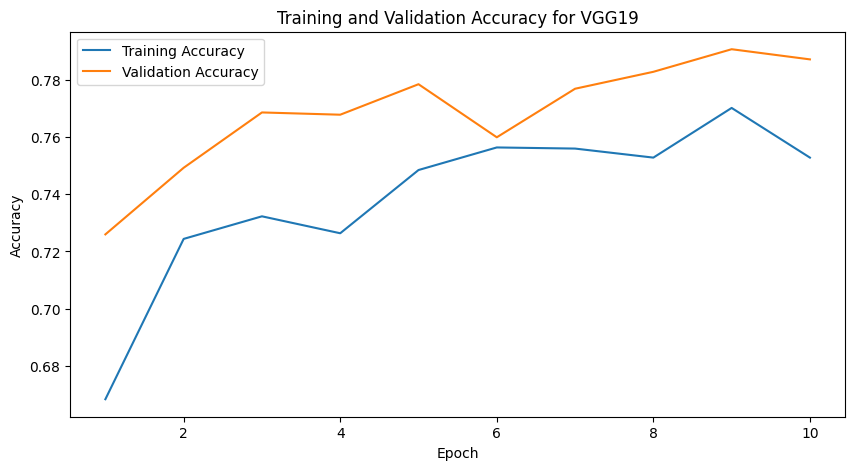

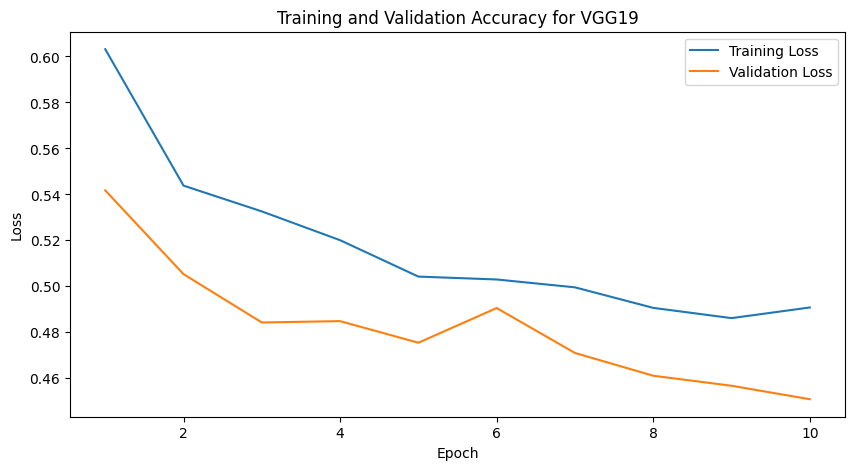

In [ ]:
# Move the accuracies to CPU
train_acc_vgg19_cpu = [acc.cpu().numpy() for acc in train_acc_vgg19]
valid_acc_vgg19_cpu = [acc.cpu().numpy() for acc in valid_acc_vgg19]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_vgg19_cpu) + 1), train_acc_vgg19_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_vgg19_cpu) + 1), valid_acc_vgg19_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for VGG19')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_vgg19) + 1), train_loss_vgg19, label='Training Loss')
plt.plot(range(1, len(valid_loss_vgg19) + 1), valid_loss_vgg19, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for VGG19')
plt.legend()
plt.show()

In [ ]:
print("Evaluating VGG19 on the test set...")
evaluate_model(model_vgg19, dataloaders['test'])

Evaluating VGG19 on the test set...
Accuracy: 0.7400
Precision: 0.6915
Recall: 0.8667
F1-score: 0.7692


<h4><b>ResNet18

In [ ]:
model_resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


In [ ]:
# Freeze the layers in the base model
for param in model_resnet18.parameters():
    param.requires_grad = False

# Modify the model head for fine-tuning
num_features_resnet18 = model_resnet18.fc.in_features


# Additional linear layer and dropout layer
model_resnet18.fc = nn.Sequential(
    nn.Linear(num_features_resnet18, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)


model_resnet18 = model_resnet18.to(device)


# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_resnet18.parameters(), lr=0.0001)

torch.cuda.empty_cache()
gc.collect()

7341

In [ ]:
# Train the model
model_resnet18, train_acc_resnet18, valid_acc_resnet18, train_loss_resnet18, valid_loss_resnet18 = train_model(model_resnet18, criterion, optimizer_ft, dataloaders,
                                                             num_epochs)

Epoch 1/10
----------
train Loss: 0.6420 Acc: 0.6262
valid Loss: 0.5688 Acc: 0.7535
Epoch 2/10
----------
train Loss: 0.5590 Acc: 0.7204
valid Loss: 0.5138 Acc: 0.7721
Epoch 3/10
----------
train Loss: 0.5327 Acc: 0.7350
valid Loss: 0.4816 Acc: 0.7930
Epoch 4/10
----------
train Loss: 0.5133 Acc: 0.7472
valid Loss: 0.4682 Acc: 0.7875
Epoch 5/10
----------
train Loss: 0.4942 Acc: 0.7555
valid Loss: 0.4559 Acc: 0.7950
Epoch 6/10
----------
train Loss: 0.4790 Acc: 0.7725
valid Loss: 0.4418 Acc: 0.7997
Epoch 7/10
----------
train Loss: 0.4762 Acc: 0.7756
valid Loss: 0.4359 Acc: 0.7950
Epoch 8/10
----------
train Loss: 0.4528 Acc: 0.7843
valid Loss: 0.4277 Acc: 0.8080
Epoch 9/10
----------
train Loss: 0.4646 Acc: 0.7709
valid Loss: 0.4189 Acc: 0.8147
Epoch 10/10
----------
train Loss: 0.4480 Acc: 0.7910
valid Loss: 0.4123 Acc: 0.8206


In [ ]:
print("Evaluating ResNet18 on the test set...")
evaluate_model(model_resnet18, dataloaders['test'])

Evaluating ResNet18 on the test set...
Accuracy: 0.7867
Precision: 0.8116
Recall: 0.7467
F1-score: 0.7778


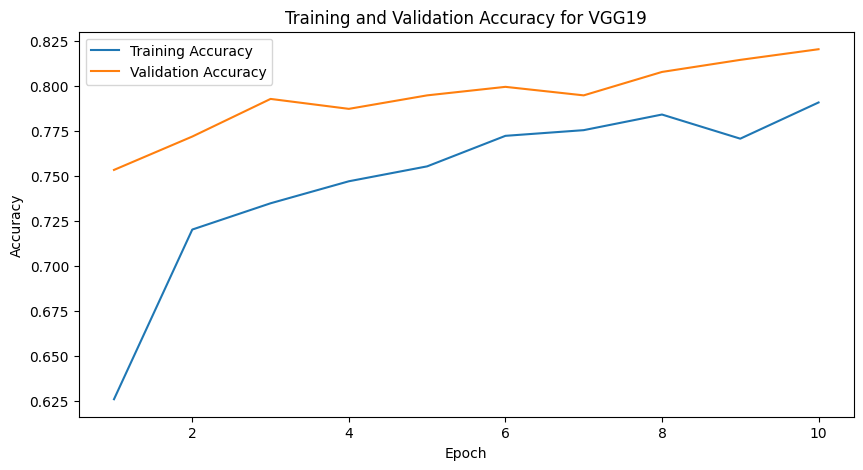

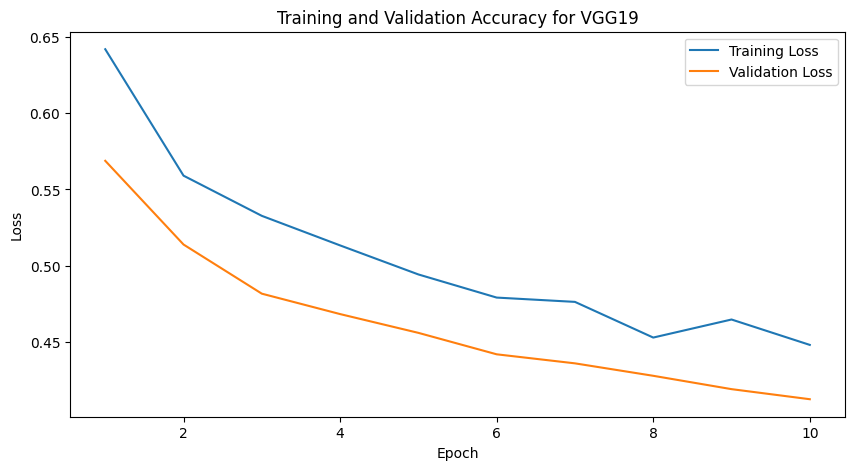

In [ ]:
# Move the accuracies to CPU
train_acc_resnet18_cpu = [acc.cpu().numpy() for acc in train_acc_resnet18]
valid_acc_resnet18_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet18]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet18_cpu) + 1), train_acc_resnet18_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet18_cpu) + 1), valid_acc_resnet18_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet18')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet18) + 1), train_loss_resnet18, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet18) + 1), valid_loss_resnet18, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet18')
plt.legend()
plt.show()

<h4><b>ResNet34

In [ ]:
model_resnet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 139MB/s]


In [ ]:
# Freeze the layers in the base model
for param in model_resnet34.parameters():
    param.requires_grad = False

# Modify the model head for fine-tuning
num_features_resnet34 = model_resnet34.fc.in_features


# Additional linear layer and dropout layer
model_resnet34.fc = nn.Sequential(
    nn.Linear(num_features_resnet34, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)

model_resnet34 = model_resnet34.to(device)


# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_resnet34.parameters(), lr=0.0001)

torch.cuda.empty_cache()
gc.collect()

7336

In [ ]:
# Train the model
model_resnet34, train_acc_resnet34, valid_acc_resnet34, train_loss_resnet34, valid_loss_resnet34 = train_model(model_resnet34, criterion, optimizer_ft, dataloaders,
                                                             num_epochs)

Epoch 1/10
----------
train Loss: 0.6533 Acc: 0.6108
valid Loss: 0.5755 Acc: 0.7362
Epoch 2/10
----------
train Loss: 0.5695 Acc: 0.7173
valid Loss: 0.5237 Acc: 0.7603
Epoch 3/10
----------
train Loss: 0.5374 Acc: 0.7315
valid Loss: 0.4903 Acc: 0.7760
Epoch 4/10
----------
train Loss: 0.5127 Acc: 0.7484
valid Loss: 0.4739 Acc: 0.7815
Epoch 5/10
----------
train Loss: 0.5086 Acc: 0.7425
valid Loss: 0.4788 Acc: 0.7748
Epoch 6/10
----------
train Loss: 0.4964 Acc: 0.7520
valid Loss: 0.4527 Acc: 0.7906
Epoch 7/10
----------
train Loss: 0.4873 Acc: 0.7603
valid Loss: 0.4435 Acc: 0.8013
Epoch 8/10
----------
train Loss: 0.4690 Acc: 0.7709
valid Loss: 0.4429 Acc: 0.7993
Epoch 9/10
----------
train Loss: 0.4594 Acc: 0.7772
valid Loss: 0.4303 Acc: 0.8076
Epoch 10/10
----------
train Loss: 0.4643 Acc: 0.7748
valid Loss: 0.4295 Acc: 0.7930


In [ ]:
print("Evaluating RestNet34 on the test set...")
evaluate_model(model_resnet34, dataloaders['test'])

Evaluating RestNet34 on the test set...
Accuracy: 0.8067
Precision: 0.7875
Recall: 0.8400
F1-score: 0.8129


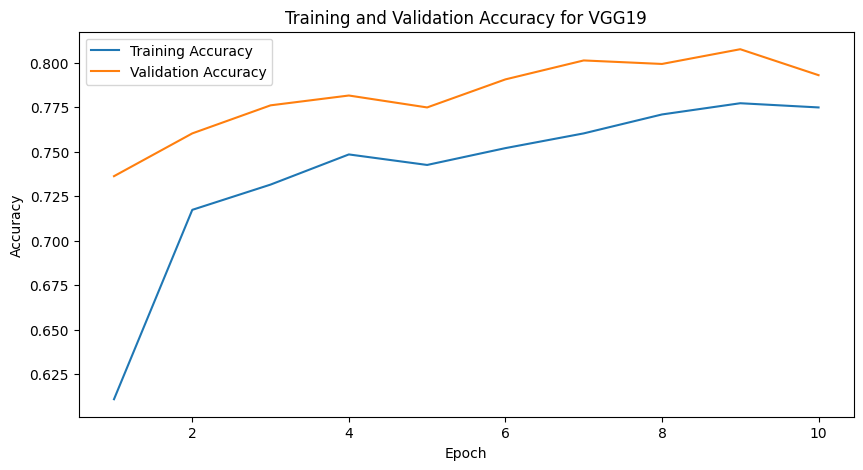

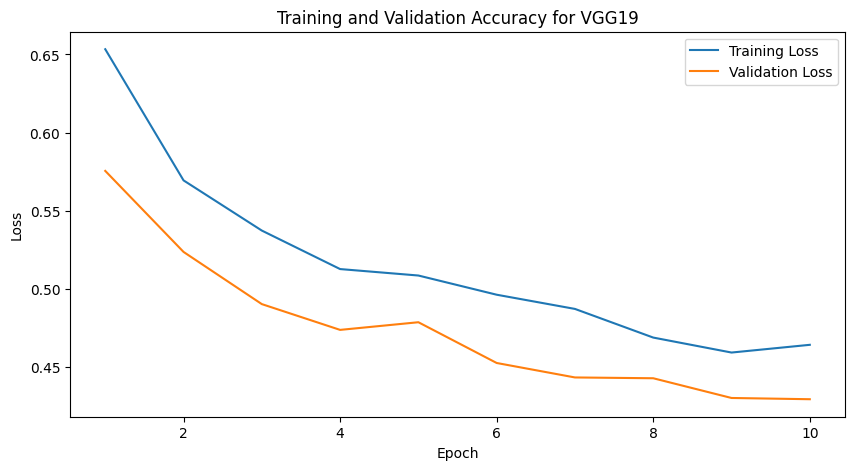

In [ ]:
# Move the accuracies to CPU
train_acc_resnet34_cpu = [acc.cpu().numpy() for acc in train_acc_resnet34]
valid_acc_resnet34_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet34]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet34_cpu) + 1), train_acc_resnet34_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet34_cpu) + 1), valid_acc_resnet34_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet34')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet34) + 1), train_loss_resnet34, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet34) + 1), valid_loss_resnet34, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet34')
plt.legend()
plt.show()

<h4><b>ResNet50

In [ ]:
model_resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


In [ ]:
# Freeze the layers in the base model
for param in model_resnet50.parameters():
    param.requires_grad = False


# Modify the model head for fine-tuning
num_features_resnet50 = model_resnet50.fc.in_features

# Additional linear layer and dropout layer
model_resnet50.fc = nn.Sequential(
    nn.Linear(num_features_resnet50, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)


model_resnet50 = model_resnet50.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_resnet50.parameters(), lr=0.0001)

torch.cuda.empty_cache()
gc.collect()

7243

In [ ]:
# Train the model
model_resnet50, train_acc_resnet50, valid_acc_resnet50, train_loss_resnet50, valid_loss_resnet50 = train_model(model_resnet50, criterion, optimizer_ft, dataloaders,
                                                             num_epochs)

Epoch 1/10
----------
train Loss: 0.6275 Acc: 0.6443
valid Loss: 0.5483 Acc: 0.7543
Epoch 2/10
----------
train Loss: 0.5510 Acc: 0.7303
valid Loss: 0.5082 Acc: 0.7579
Epoch 3/10
----------
train Loss: 0.5241 Acc: 0.7413
valid Loss: 0.4716 Acc: 0.7898
Epoch 4/10
----------
train Loss: 0.4905 Acc: 0.7642
valid Loss: 0.4509 Acc: 0.7938
Epoch 5/10
----------
train Loss: 0.4778 Acc: 0.7843
valid Loss: 0.4439 Acc: 0.8024
Epoch 6/10
----------
train Loss: 0.4688 Acc: 0.7788
valid Loss: 0.4371 Acc: 0.8032
Epoch 7/10
----------
train Loss: 0.4658 Acc: 0.7756
valid Loss: 0.4233 Acc: 0.8060
Epoch 8/10
----------
train Loss: 0.4625 Acc: 0.7831
valid Loss: 0.4444 Acc: 0.7879
Epoch 9/10
----------
train Loss: 0.4508 Acc: 0.7953
valid Loss: 0.4372 Acc: 0.7950
Epoch 10/10
----------
train Loss: 0.4484 Acc: 0.7886
valid Loss: 0.4118 Acc: 0.8170


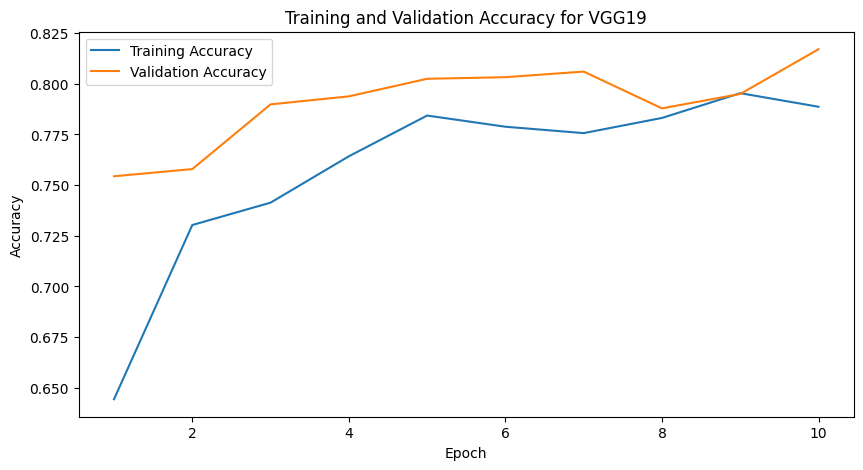

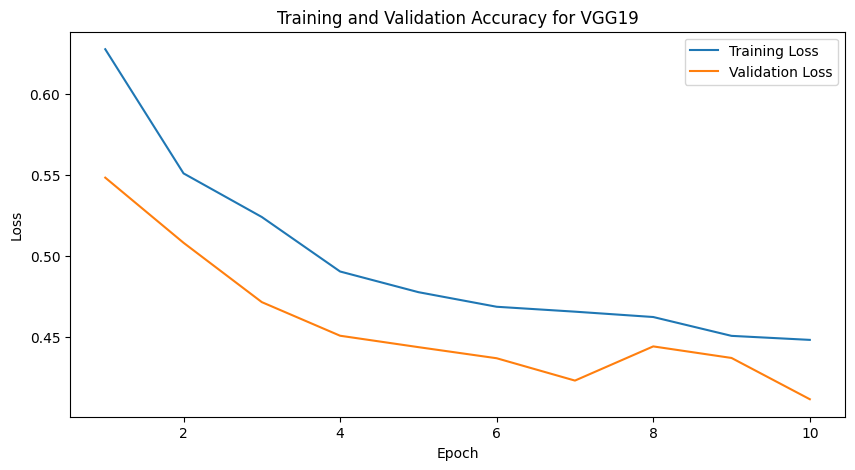

In [ ]:
# Move the accuracies to CPU
train_acc_resnet50_cpu = [acc.cpu().numpy() for acc in train_acc_resnet50]
valid_acc_resnet50_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet50]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet50_cpu) + 1), train_acc_resnet50_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet50_cpu) + 1), valid_acc_resnet50_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet50')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet50) + 1), train_loss_resnet50, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet50) + 1), valid_loss_resnet50, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet50')
plt.legend()
plt.show()

In [ ]:
print("Evaluating ResNet50 on the test set...")
evaluate_model(model_resnet50, dataloaders['test'])

Evaluating ResNet50 on the test set...
Accuracy: 0.8067
Precision: 0.7949
Recall: 0.8267
F1-score: 0.8105
